In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
digits= load_digits()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)

import warnings
warnings.filterwarnings('ignore')

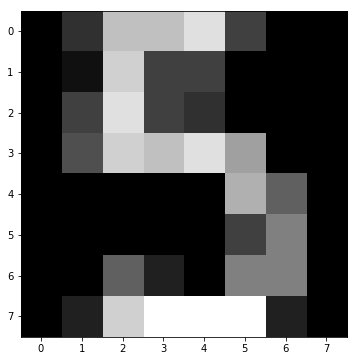

In [2]:
plt.rcParams['figure.figsize'] = 8,6
plt.imshow(np.reshape(x_train[1], (8,8)), cmap=plt.cm.gray);
plt.show()

In [3]:
from sklearn.model_selection import StratifiedKFold

#define a function that run 5-fold cross validation and take the average of the validation accuracy to indicate performance.
def lr_mod(model,x_train,y_train):
    acc_cv=0
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(x_train, y_train)
    for tr_index, tst_index in skf.split(x_train, y_train):

        x_tr, x_valid = x_train[tr_index], x_train[tst_index]
        y_tr, y_valid = y_train[tr_index], y_train[tst_index]
        model.fit(x_tr, y_tr)
        ypred = model.predict(x_valid)
        #subtracting validation matrix from the prediction matrix, the number of zeros is the correct prediction
        accu = 1-np.count_nonzero(ypred-y_valid)/len(y_valid)
        acc_cv += accu
        
    return acc_cv/5




In [4]:
from sklearn.linear_model import LogisticRegression
old_model = LogisticRegression()
acc_t=lr_mod(old_model,x_train,y_train)
print("training set accuracy",acc_t)
#a simple logistic regression model

old_model.fit(x_train, y_train)
y_pred=old_model.predict(x_test)
acc_test = 1-np.count_nonzero(y_pred-y_test)/len(y_test)
acc_test#test set accuracy

training set accuracy 0.9596550749080613


0.95

In [5]:
# L2 Ridge
from sklearn.linear_model import RidgeClassifier as rid
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20] #list of C values
ridge_acc=[]
for i in range(10):
    ridge_mod = rid(alpha = alpha_ridge[i], normalize=True)
    acc_r=lr_mod(ridge_mod,x_train,y_train)# fit model for every C values
    print(acc_r) #validation accuracy
    ridge_acc.append(acc_r)

sl_alpha=alpha_ridge[np.argmax(ridge_acc)]#select the one with maximun validation accuracy
print("\n select alpha =", sl_alpha)
ridge_mod=rid(alpha=sl_alpha,normalize=True)
print("validation accuracy is ",np.max(ridge_acc))#validation accuracy

ridge_mod.fit(x_train, y_train)
y_pred=ridge_mod.predict(x_test)
acc_rid = 1-np.count_nonzero(y_pred-y_test)/len(y_test)
acc_rid# test set accuracy

0.938149822901343
0.938149822901343
0.938149822901343
0.938149822901343
0.938149822901343
0.9388562336162856
0.9249325146092392
0.8853423307847439
0.8659026082340393
0.8415107515019258

 select alpha = 0.01
validation accuracy is  0.938856233616


0.9277777777777778

In [6]:
#L1 lasso
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]#list of C values
lasso_acc=[]
for i in range(10):
    lasso_mod = LogisticRegression(penalty='l1',C=alpha_lasso[i])
    acc_l=lr_mod(lasso_mod,x_train,y_train)#fit model
    lasso_acc.append(acc_l)

sl_alpha=alpha_lasso[np.argmax(lasso_acc)]#select highest validation accuracy model
print("select alpha =", sl_alpha)
lasso_mod = LogisticRegression(penalty='l1',C=sl_alpha)
print("validation accuracy =",np.max(lasso_acc))#validation

lasso_mod.fit(x_train, y_train)
y_pred_l=lasso_mod.predict(x_test)
acc_las = 1-np.count_nonzero(y_pred_l-y_test)/len(y_test)
acc_las#tese set accuracy

select alpha = 1
validation accuracy = 0.95619238361


0.9527777777777777

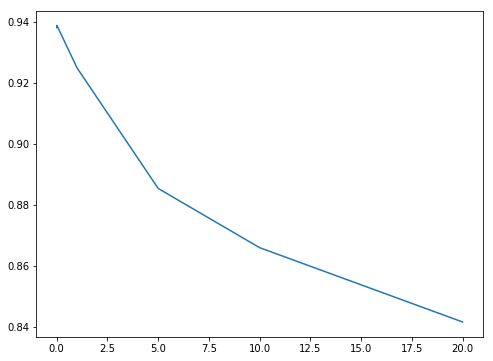

In [7]:
plt.plot(alpha_ridge,ridge_acc)#plot ridge graph
plt.show()

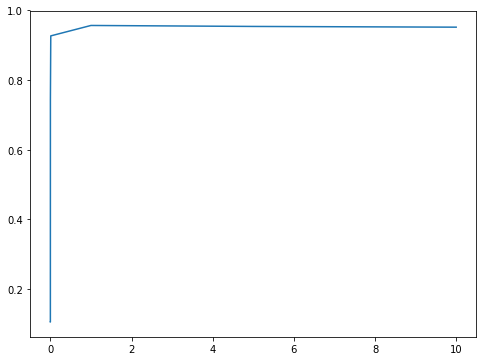

In [8]:
plt.plot(alpha_lasso,lasso_acc)#plot lasso graph
plt.show()

In [22]:
import tensorflow as tf
tf.reset_default_graph()

In [23]:
from datetime import datetime
import os
import pathlib

t = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
log_dir = "tf_logs"
logd = "/tmp/{}/r{}/".format(log_dir, t)

# Then every time you have specified a graph run:
# file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Make directory if it doesn't exist

from pathlib import Path
home = str(Path.home())

logdir = os.path.join(os.sep,home,logd)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [24]:
# TensorBoard Graph visualizer in notebook
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)
#load data

In [26]:
import keras
#define input, output sizes
img_dim = 8*8
num_classes = 10

#reshape input matrix  (?,64)
x_train = x_train.reshape(x_train.shape[0], img_dim)
x_test = x_test.reshape(x_test.shape[0], 64)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#reshape output values to labels  (?,10)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [27]:
# Define input
x = tf.placeholder(tf.float32,shape = [None,64]) 

W = tf.Variable(tf.zeros([64, 10])) # number of weights
b = tf.Variable(tf.zeros([10])) # number of bias terms

y_hat = tf.nn.softmax(tf.matmul(x, W) + b) 
# define what we'll take the softmax activation on
y = tf.placeholder(tf.float32, [None, 10])

# define loss function
ce = tf.reduce_mean(-tf.reduce_sum( y* tf.log(y_hat),axis=1))

In [28]:
#define training step
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(ce)

In [29]:
#accuracy function
def acc():
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_hat,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tr_ac=sess.run(accuracy, feed_dict={x: x_train, y: y_train})
    vd_ac=sess.run(accuracy, feed_dict={x: x_test, y: y_test})
    print(vd_ac)
    return tr_ac,vd_ac

In [30]:

#new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [31]:
#create lists for plots
i_list=[]
tr_list=[]
vl_list=[]
#find the number of batches for 100 batch size
n_batches=np.floor(len(x_train)/100)
for i in range(200):
    #shuffle and split the training set data -----batching
    shuffled_idx = np.random.permutation(len(x_train))  
    
    x_batches = np.array_split(x_train[shuffled_idx], n_batches)
    y_batches = np.array_split(y_train[shuffled_idx], n_batches)
    for x_batch, y_batch in zip(x_batches, y_batches):
        sess.run(train_step, feed_dict={x: x_batch, y: y_batch})
    #record every ten set of values
    if i%10==0:
        Train_ac,Valid_ac=acc()
        i_list.append(i)
        tr_list.append(Train_ac)
        vl_list.append(Valid_ac)
        

0.838889
0.927778
0.941667
0.95
0.95
0.952778
0.958333
0.961111
0.958333
0.963889
0.963889
0.966667
0.966667
0.963889
0.963889
0.963889
0.969444
0.969444
0.969444
0.969444


In [32]:
acc()

0.969444


(0.98260266, 0.96944445)

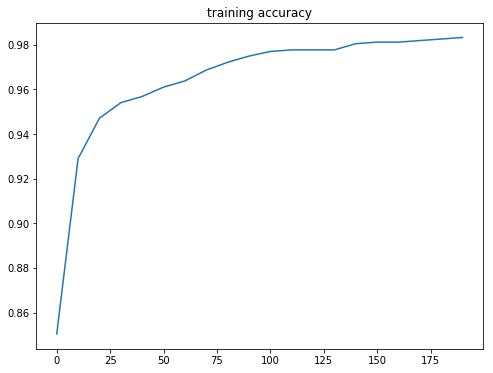

In [33]:
plt.plot(i_list,tr_list)
plt.title('training accuracy')
plt.show()

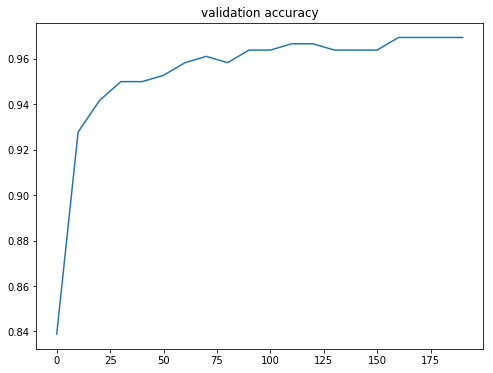

In [34]:
plt.plot(i_list,vl_list)
plt.title('validation accuracy')
plt.show()

In [35]:
graph1 = tf.Graph()
#show grpah in tensorboard
with graph1.as_default():

    with tf.name_scope('hidden') as scope:
        x = tf.placeholder(tf.float32,shape = [None,784]) 
        W = tf.Variable(tf.zeros([784, 10])) # number of weights
        b = tf.Variable(tf.zeros([10])) # number of bias terms
        y_hat = tf.nn.softmax(tf.matmul(x, W) + b)
    with tf.name_scope('second') as scope:
        y = tf.placeholder(tf.float32, [None, 10])
        ce = tf.reduce_mean(-tf.reduce_sum( y* tf.log(y_hat),axis=1))
    sess1 = tf.Session(graph=graph1)

show_graph(graph1)
#write graph to the temp directory to print the graph in tensorboard
file_writer = tf.summary.FileWriter(logdir, graph1)

In [36]:
logdir
#tensorboard --logdir=

'C:/tmp/tf_logs/r20180402000652/'

In [37]:
## Part 2
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)
n=x_train.max()
#normalize the data by dividing it by the maximun value (16)
x_train /= n
x_test /= n

In [38]:
# define features
n_inputs = 8*8  # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

tf.reset_default_graph()
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [39]:
def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [40]:
keep_prob=0.9 #dropout =0.1 so keep = 0.9

# three hidden layers
with tf.name_scope("dnn"):
        hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                               activation=tf.nn.tanh)
        hidden1 = tf.nn.dropout(hidden1, keep_prob)
        hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                               activation=tf.nn.tanh)
        hidden2 = tf.nn.dropout(hidden2, keep_prob)
        hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",
                               activation=tf.nn.tanh)
        hidden3 = tf.nn.dropout(hidden3, keep_prob)
        logits = neuron_layer(hidden3, n_outputs, name="outputs")

    

In [41]:
with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [42]:

# gradient descent parameters
n_epochs = 1000
batch_size = 100
n_batches=np.floor(len(x_train)/100)

q2epoch=[]
q2train=[]
q2val=[]
#initialize
init = tf.global_variables_initializer()
graph2 = tf.Graph()
with tf.Session() as sess2:
    
    with graph2.as_default():    
        init.run()
        for epoch in range(n_epochs):
            #shuffle and split -----batching
            shuffled_idx = np.random.permutation(len(x_train))  
    
            x_batches = np.array_split(x_train[shuffled_idx], n_batches)
            y_batches = np.array_split(y_train[shuffled_idx], n_batches)
            for x_batch, y_batch in zip(x_batches, y_batches):
                sess2.run(training_op, feed_dict={X: x_batch, y: y_batch})
            #accuracy
            acc_train = accuracy.eval(feed_dict={X: x_batch, y: y_batch},session=sess2)
            acc_val = accuracy.eval(feed_dict={X: x_test, y: y_test})
            #print values
            if (epoch%50==0) | (epoch==999):
                print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
                q2epoch.append(epoch)
                q2train.append(acc_train)
                q2val.append(acc_val)



0 Train accuracy: 0.147059 Val accuracy: 0.102778
50 Train accuracy: 0.72549 Val accuracy: 0.683333
100 Train accuracy: 0.803922 Val accuracy: 0.786111
150 Train accuracy: 0.872549 Val accuracy: 0.85
200 Train accuracy: 0.823529 Val accuracy: 0.886111
250 Train accuracy: 0.921569 Val accuracy: 0.886111
300 Train accuracy: 0.901961 Val accuracy: 0.905556
350 Train accuracy: 0.911765 Val accuracy: 0.913889
400 Train accuracy: 0.980392 Val accuracy: 0.927778
450 Train accuracy: 0.941176 Val accuracy: 0.936111
500 Train accuracy: 0.921569 Val accuracy: 0.922222
550 Train accuracy: 0.921569 Val accuracy: 0.925
600 Train accuracy: 0.960784 Val accuracy: 0.944444
650 Train accuracy: 0.980392 Val accuracy: 0.947222
700 Train accuracy: 0.960784 Val accuracy: 0.930556
750 Train accuracy: 0.95098 Val accuracy: 0.947222
800 Train accuracy: 0.941176 Val accuracy: 0.944444
850 Train accuracy: 0.970588 Val accuracy: 0.936111
900 Train accuracy: 0.980392 Val accuracy: 0.95
950 Train accuracy: 0.990196

In [43]:
file_writer = tf.summary.FileWriter(logdir, graph2)#print graph to tensorboard

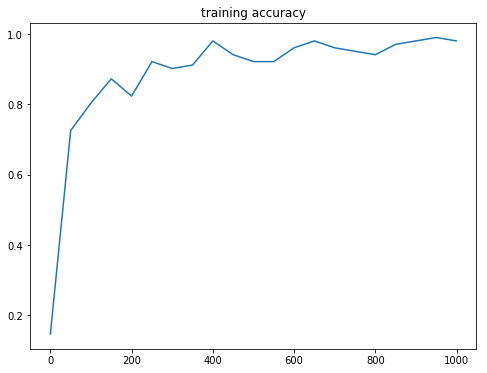

In [44]:
plt.plot(q2epoch,q2train)
plt.title('training accuracy')
plt.show()

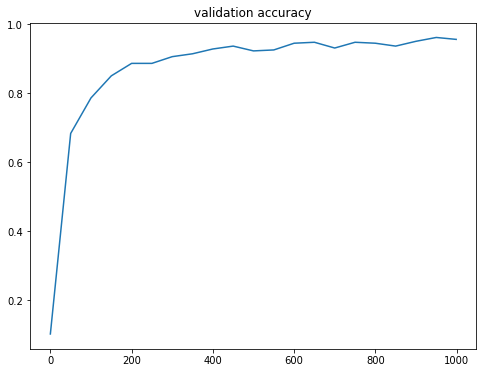

In [45]:
plt.plot(q2epoch,q2val)
plt.title('validation accuracy')
plt.show()

In [46]:
###################Part 3
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)
#reload data

In [47]:
# define features
n_inputs = 8*8  # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

tf.reset_default_graph()
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [48]:
def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        #####batch normalization
        
        ############# beta
        beta = tf.Variable(tf.zeros([n_neurons]))
        ##################gamma
        gamma = tf.Variable(tf.ones([n_neurons]))
        ##############mean and variance
        mean,var=tf.nn.moments(Z,axes=[0])
        ############# obtain moving average
        MA=tf.train.ExponentialMovingAverage(decay=0.5)
        with tf.control_dependencies([MA.apply([mean,var])]):
            mean,var = tf.identity(mean),tf.identity(var)
        
        ### ((Z-mean)/std)*gamma +beta
        Z=tf.nn.batch_normalization(Z,mean,var,beta,gamma,0.01)
        if activation is not None:
            return activation(Z)
        else:
            return Z
        
        

In [49]:
keep_prob=0.9
# 3 layers, dropout = 0.1
with tf.name_scope("dnn"):
        hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                               activation=tf.nn.tanh)
        hidden1 = tf.nn.dropout(hidden1, keep_prob)
        hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                               activation=tf.nn.tanh)
        hidden2 = tf.nn.dropout(hidden2, keep_prob)
        hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",
                               activation=tf.nn.tanh)
        hidden3 = tf.nn.dropout(hidden3, keep_prob)
        logits = neuron_layer(hidden3, n_outputs, name="outputs")

    

In [50]:
with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [51]:

#parameters
n_epochs = 1000
batch_size = 100
n_batches=np.floor(len(x_train)/100)

q3epoch=[]
q3train=[]
q3val=[]
init = tf.global_variables_initializer()

graph3 = tf.Graph()
with tf.Session() as sess3:
    
    with graph3.as_default():    
        init.run()
        for epoch in range(n_epochs):
            #batching
            shuffled_idx = np.random.permutation(len(x_train))  
    
            x_batches = np.array_split(x_train[shuffled_idx], n_batches)
            y_batches = np.array_split(y_train[shuffled_idx], n_batches)
            for x_batch, y_batch in zip(x_batches, y_batches):
                
                sess3.run(training_op, feed_dict={X: x_batch, y: y_batch})
            acc_train = accuracy.eval(feed_dict={X: x_batch, y: y_batch},session=sess3)
            acc_val = accuracy.eval(feed_dict={X: x_test, y: y_test})
            if (epoch%50==0) | (epoch==999):
                print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
                q3epoch.append(epoch)
                q3train.append(acc_train)
                q3val.append(acc_val)


0 Train accuracy: 0.137255 Val accuracy: 0.144444
50 Train accuracy: 0.803922 Val accuracy: 0.755556
100 Train accuracy: 0.813725 Val accuracy: 0.852778
150 Train accuracy: 0.921569 Val accuracy: 0.866667
200 Train accuracy: 0.921569 Val accuracy: 0.894444
250 Train accuracy: 0.931373 Val accuracy: 0.902778
300 Train accuracy: 0.95098 Val accuracy: 0.919444
350 Train accuracy: 0.911765 Val accuracy: 0.916667
400 Train accuracy: 0.931373 Val accuracy: 0.925
450 Train accuracy: 0.882353 Val accuracy: 0.936111
500 Train accuracy: 0.911765 Val accuracy: 0.930556
550 Train accuracy: 0.980392 Val accuracy: 0.944444
600 Train accuracy: 0.941176 Val accuracy: 0.930556
650 Train accuracy: 0.960784 Val accuracy: 0.933333
700 Train accuracy: 0.911765 Val accuracy: 0.930556
750 Train accuracy: 0.911765 Val accuracy: 0.944444
800 Train accuracy: 0.960784 Val accuracy: 0.955556
850 Train accuracy: 0.921569 Val accuracy: 0.936111
900 Train accuracy: 0.931373 Val accuracy: 0.938889
950 Train accuracy:

In [53]:
file_writer = tf.summary.FileWriter(logdir, graph3)
logdir
#tensorboard --logdir=

'C:/tmp/tf_logs/r20180402000652/'

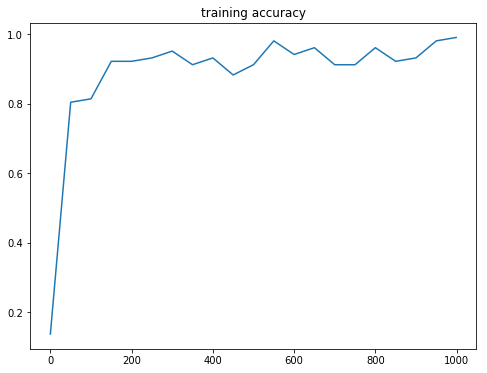

In [54]:
plt.plot(q3epoch,q3train)
plt.title('training accuracy')
plt.show()

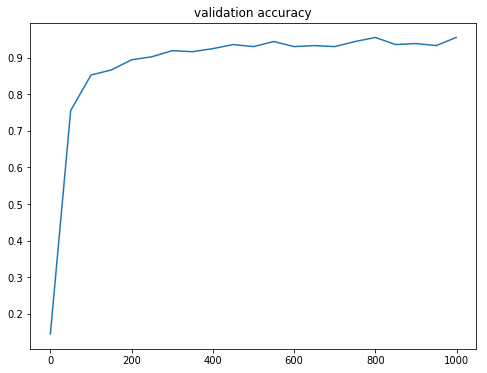

In [55]:
plt.plot(q3epoch,q3val)
plt.title('validation accuracy')
plt.show()